參考 link :https://www.kaggle.com/code/ryotayoshinobu/foursquare-lightgbm-baseline
This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [1]:
! pip uninstall lightgbm -y
! pip install lightgbm==3.3.1
! pip install sentence_transformers

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 5.2 MB/s 
     |████████████████████████████████| 4.2 MB 15.8 MB/s 
     |████████████████████████████████| 1.2 MB 60.7 MB/s 
     |████████████████████████████████| 86 kB 1.1 MB/s 
     |████████████████████████████████| 596 kB 72.2 MB/s 
     |████████████████████████████████| 6.6 MB 68.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=985a0f1a0df5259c2c7df3c23cfe85ce6ca84a7aef81bc74ec5264972801280b
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c foursquare-location-matching
! unzip foursquare-location-matching.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 156M/159M [00:02<00:00, 65.8MB/s]
100% 159M/159M [00:02<00:00, 67.4MB/s]
Archive:  foursquare-location-matching.zip
  inflating: pairs.csv               
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 宣告一個專門放參數的 class
class CFG: # configuration
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

# %cd /content/drive/MyDrive/kaggle/foursquare-location-matching/{CFG.expID}

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

In [5]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
test[CFG.target] = "TEST"

train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


# Devide Train Data into about 600K×2

In [6]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [7]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,0.0
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0.0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0


# 資料代入 / 插補 / 填補 Data Imputation

In [8]:
from sklearn.neighbors import KNeighborsRegressor
# 把每一個地點都加上 另外一個最近地點的資訊
def add_neighbor_features(df):
    dfs = []
    # 需要 id 不然不沒辦法做後方 matches 的 set、沒辦法算分數
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
#     columns = ['name', 'address', 'city', 'state',
#             'zip', 'country', 'url', 'phone', 'categories']
#     for c in columns:
#         df[c] = df[c].astype(str).str.lower()
            
    # 把相同國家的 row 放進同一個 dataframe 裡面
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        # n_neighbors 表示要參考附近的幾筆資料才決定屬於哪一群
#         print(len(country_df))
        k = min(len(country_df), CFG.n_neighbors)
        knn = KNeighborsRegressor(n_neighbors=k, 
                                  metric='haversine', n_jobs=-1)
        
        # 使用相同的"國家群"進行訓練
        # 同個國家的資料當成一群進行訓練
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        
        # 得出分群後的資料，回傳每個點與最近的幾個點的距離與 indices
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
#         print("dists, nears\n",dists,nears)
        # 將 n_neighbors 各點的資料呈現在 country_df 上
        targets = country_df[CFG.target].values
        for i in range(k):
            country_df[f"d_near_{i}"] = dists[:, i]
#             print("d_near_",i,dists[:, i])
            country_df[f"near_target_{i}"] = targets[nears[:, i]]
            for c in columns:
                country_df[f"near_{c}_{i}"] = country_df[c].values[nears[:, i]]
        # 若整個國家的資料點數量小於預設所需的 k ，則將多出的部分填補為 nan
        for i in range(k, CFG.n_neighbors):
            country_df[f"d_near_{i}"] = np.nan
            country_df[f"near_target_{i}"] = np.nan
            for c in columns:
                country_df[f"near_{c}_{i}"] = np.nan

        dfs.append(country_df)
#         break
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [9]:
# original_train = train

In [10]:
# add_neighbor_features(original_train)

In [11]:
train.tail()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set
1138807,E_ffffb80854f713,青ガエル,35.659020,139.700780,NaN,渋谷区,東京都,150-0043,JP,NaN,NaN,NaN,P_7ccbeab96cd82e,1.0
1138808,E_ffffbf9a83e0ba,Deshon Place,40.872116,-79.945343,325 New Castle Rd,Butler,PA,16001,US,NaN,NaN,Housing Developments,P_db0abc418e7365,1.0
1138809,E_ffffc572b4d35b,İzmir Adnan Menderes Havaalanı,38.423733,27.142826,NaN,İzmir,NaN,NaN,TR,NaN,NaN,Airport Services,P_ae96252a6a9380,0.0
1138810,E_ffffca745329ed,焼肉 和家,35.710712,139.775000,上野6-13-6,Taitō,東京都,110-0005,JP,NaN,338362989,BBQ Joints,P_146662f246d418,0.0
1138811,E_ffffe6f4652fbb,Waihi Beach,-37.417042,175.950466,NaN,Waihi Beach,Bay Of Plenty,3611,NZ,NaN,NaN,Surf Spots,P_ea6578bf39b406,1.0


In [12]:
# 擴充 train 的 n_neighbors 的資料
train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_9,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_bb40eb6b8aa6c9,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas


### 測試 word embedding

In [13]:
name_embeddings = model.encode([train.iloc[1]['name'],train.iloc[0]['name']])
categories_embeddings = model.encode(train.iloc[1]['categories'])

In [14]:
float(util.cos_sim(name_embeddings[0], name_embeddings[1])[0][0])

0.1534162163734436

# Analysis: Threshold


## 順位法
以距離順位(k)為基準分析趨勢：
1. 判斷多近「還有機會」是同個 POI
    * 後面的結果會覆蓋前面的結果
2. (?) 判斷多近「就會」是同個 POI
    * p.s.「多近」是以距離順位（第幾近）來判斷，而非是以絕對距離來看。
3. 判斷第一個 match 在哪 (0)

In [15]:
train.loc[:,"target"] = 0
# 1.
# [x] 判斷前幾個相同分群的經緯度是相同 POI
## 有可能第 2 個不同但第 4 個同，而 4 覆蓋掉 2，因此不代表前四個都是相同
## [?] 但此處的問題為，把經緯度分群當成唯一影響，所以才直接照順序決定 target(同一個 POI 的情況下，最大的 i)

# for i in range(CFG.n_neighbors):
#     print(train[CFG.target]==train[f"near_target_{i}"])
#     train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i

# 2. (after 1.)
# # wtf is that? >by Howard
train.loc[:,"not done"] = True
for i in tqdm(range(CFG.n_neighbors)):
    train.loc[train[CFG.target]!=train[f"near_target_{i}"], "not done"] = False
    train.loc[(train[CFG.target]==train[f"near_target_{i}"]) & (train["not done"]), "target"] = i

# 3.
# for i in range(CFG.n_neighbors-1, -1, -1):
# #     print(train[CFG.target]==train[f"near_target_{i}"])
#     train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i
    
    
# list(train.columns)
train['target'].tail(10)

  0%|          | 0/10 [00:00<?, ?it/s]

569396    1
569397    1
569398    1
569399    1
569400    0
569401    0
569402    0
569403    0
569404    0
569405    0
Name: target, dtype: int64

In [16]:
train['target'].max()

9

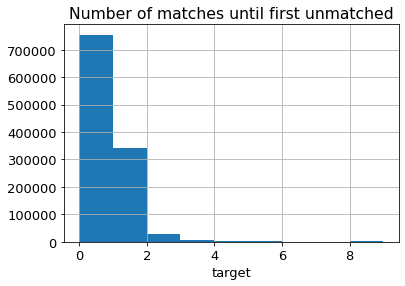

In [17]:
plt.hist(train["target"], bins=sorted(train["target"].unique()))
plt.grid()
plt.xlabel("target")
plt.title('Number of matches until first unmatched')
# plt.title('Number of the last match')
plt.show()

## 絕對距離法
直接以距離的值來判定

In [18]:
# for index, row in train.iterrows():
# #     print("row", row)
# #     print("row['target']", row["target"])
# #     print("row[row['target']]", row[row["target"]])
# #     if index == 3:
# #         break
#     ## wtf is that? >by Howard
#     row["max_dist"] = row[row["target"]]


# for i in range(CFG.n_neighbors):
#     train.loc[train[CFG.target]!=train[f"near_target_{i}"], "done"] = True
#     ## Assign i to all elements in train['target'] where train['POI']==train[near_target_i]
#     train.loc[(train[CFG.target]==train[f"near_target_{i}"]) & (train["done"] != True), "target"] = train[f"d_near_{i}"]
    
# list(train.columns)
# train['target'].head(10)

# Validation

## Two-way Hash
用雜湊表來將正確答案產出

In [19]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics

## 將input dataframe 轉成 dict，再拿出 id 與 poi 用 dict 回傳
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

## 將input dataframe 轉成 dict，再以 poi 為 index、取出"屬於此 poi"的 id set 用 dict 回傳
def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

## 比對
利用 KNN 的結果做出預測，再與正確答案做比對

In [20]:
## 已有 matches
def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        # 找出與該 id 相同 poi 之所有 id
        targets = poi2ids[id2poi[id_str]]
        # 整理 matches 格式 (根據 train + knn 所得) (以空格分割)
        preds = set(matches.split())
        # 比分數
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

In [21]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9,target,not done
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,1,False
1,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,c/ cap del carrer,la massana,ordino,nan,ad,nan,376837190,restaurants,1,False
2,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,ad,ad,nan,nan,ad,nan,nan,american restaurants,0,False
3,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,1,False
4,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,871787,"hotels, resorts, buffets",0,False


In [22]:
scores = []
# 用 poi 去 check 每一個 n_neighors 的 poi，把 poi 相同的 id 加在 matches 這個新增的 column
# 此外這裡每次多考慮一個 neighbor，就多算一次分數
train["matches"] = ""
for i in tqdm(range(CFG.n_neighbors)):
    # 一次是看某一個i，直的一整大排去賦值
    idx = train[CFG.target]==train[f"near_target_{i}"]
    # idx 裡面是 true 才會 access 到那一個 row
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]
    # 算分數囉～
    scores.append(get_score(train))
# 把紀錄刪光光
train["matches"] = None

  0%|          | 0/10 [00:00<?, ?it/s]

[0.6484506075339209, 0.8020225149439327, 0.8325236657705021, 0.8501963189455756, 0.8612881015205666, 0.8695578186566711, 0.8760523984244069, 0.8814800634456692, 0.8860158384529265, 0.8898691517949306]


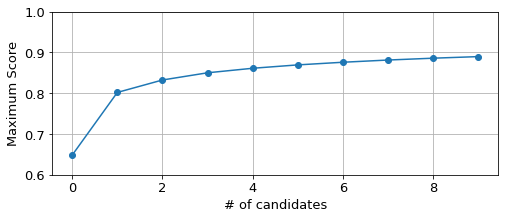

In [23]:
# 會發現每多考慮一個 candidate 分數就可以提高
plt.subplots(figsize=(8, 3), facecolor="white")
print(scores)
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [24]:
# 清記憶體垃圾
# del train
gc.collect()

2295

In [25]:
train = train.drop('matches', axis=1)
train = train.drop('not done', axis=1)

In [26]:
train.iloc[0]

id                          E_1104d3664585a4
name                              mamá maría
latitude                           42.508166
longitude                           1.525205
address                    av. meritxell, 25
                              ...           
near_country_9                            ad
near_url_9           http://www.vallnord.com
near_phone_9                          737020
near_categories_9                  ski areas
target                                     1
Name: 0, Length: 135, dtype: object

# Feature Engineering

In [27]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 8.5 MB/s 
     |████████████████████████████████| 1.8 MB 76.8 MB/s 
     |████████████████████████████████| 103 kB 90.5 MB/s 


In [28]:
%load_ext Cython

In [29]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [30]:
# 利用 Levenshtein、difflib 算出兩字串的各種 features 相異程度數值，並把數值加入到 features 內
import Levenshtein
import difflib

def _add_distance_features(args):
    # _, df = args
    df = args
    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            geshs = []
            levens = []
            jaros = []
            lcss = []
            sentence_transformer = []
            str_enter_count = 0
            for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
                # 一次只會進來一次，所以 for 是為了取值用的～
                str_enter_count += str_enter_count
                if str_enter_count >= 2:
                    print("bigger than 2","i = ", i,"c =", c)
                # 檢查是否為 NaN
                if str1==str1 and str2==str2:
                    geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                    levens.append(Levenshtein.distance(str1, str2))
                    jaros.append(Levenshtein.jaro_winkler(str1, str2))
                    lcss.append(LCS(str(str1), str(str2)))
                else:
                    geshs.append(-1)
                    levens.append(-1)
                    jaros.append(-1)
            df[f"near_{c}_{i}_gesh"] = geshs
            df[f"near_{c}_{i}_leven"] = levens
            df[f"near_{c}_{i}_jaro"] = jaros
            df[f"near_{c}_{i}_lcs"] = lcss

            # 如果是 namen, address, city, state, url, categories 的情況下，再多加一個平均的 feature
            if not c in ['country', "phone", "zip"]:
                df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
                df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
                df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
                df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
    return df

# muilty processing
def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [31]:
len(train)

1138812

In [32]:
training_data = train.sample(frac=0.8, random_state=25)

In [33]:
len(training_data)

911050

##stop plz

In [34]:
train = _add_distance_features(training_data)
# test = add_distance_features(test)

  0%|          | 0/10 [00:00<?, ?it/s]

# Delete Unusing Columns for avoiding OOM (out of memory)

In [35]:
# 在上面的 block 我們已經把新的 feature 加入到 dataframe 內了，這裡 features 的目的就是為了移掉其他不重要的 features
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']
for i in tqdm(range(CFG.n_neighbors)):
    features.append(f"d_near_{i}")
    for c in columns:        
        features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs"]
        if c in ['country', "phone", "zip"]:
            features += [f"near_{c}_{i}_leven"]
        else:
            features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

# print(features)

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
# 把剛剛所有資訊放進 train 與 test
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

# train.info()

**訓練與測試資料的格式???**
- X 包含 
    - CFT 的資訊
    - n_neighber = 10, 的所有資訊
    - n_neighber 跟 CFT.target 相關的所有字串配對分數
- y 包含
    - 相同 POI 之中，最大的 neighber

# Split Folds

In [37]:
# kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
# shuffle 應該要是 false? 這樣每個點都才會被平均的當成訓練資料，不會漏掉 > Howard
kf = StratifiedKFold(n_splits=CFG.n_splits) 
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    print(i, len(trn_idx), len(val_idx))
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

0 607366 303684
1 607367 303683
2 607367 303683


# Model Learning
使用 lightGBM 演算法

In [38]:
import lightgbm as lgbm

# n-class 表示分類結果有哪些, n_split 表示 k-fold 做幾次
def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    # 不同的 split number 就存不同的模型 k-fold cross validation> Howard
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        # 把剛剛分完群的拿出來
        trn_idx = folds!=i
        val_idx = folds==i
        # 拿出不同 dataframe
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        # 不存在就訓練
        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='logloss',  
        #       verbose=-1)
                verbose=50)
        # 存在就 load 出來, 等等跑分數
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
        # X_valid 如果是100 筆數據, 且 5個 class,那 pred 的 dimension = (100, 5)
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = f'lgbm_fold{i}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models
# 直接用 model.predict_proba 跑結果
def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

## 開始訓練資料

In [39]:
train["target"].max()

9

In [40]:
params = {
    'objective': "logloss",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                       params=params, n_class=int(train["target"].max()+ 1),
                       N_SPLITS=CFG.n_splits, folds=train["fold"].values)


  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's multi_logloss: 0.34766
[100]	valid_0's multi_logloss: 0.341471
[150]	valid_0's multi_logloss: 0.335798
[200]	valid_0's multi_logloss: 0.330246
[250]	valid_0's multi_logloss: 0.327493
[300]	valid_0's multi_logloss: 0.326636
[350]	valid_0's multi_logloss: 0.326018
[400]	valid_0's multi_logloss: 0.325619

== fold 1 ==
[50]	valid_0's multi_logloss: 0.350016

== fold 2 ==
[50]	valid_0's multi_logloss: 0.3715
[100]	valid_0's multi_logloss: 0.365564
[150]	valid_0's multi_logloss: 0.360228
[200]	valid_0's multi_logloss: 0.355311
[250]	valid_0's multi_logloss: 0.352267
[300]	valid_0's multi_logloss: 0.350924
[350]	valid_0's multi_logloss: 0.350455

CV-accuracy: 0.9114713791778717


In [41]:
# 根據不同的分組，拿出不同的 model
models = [joblib.load(f'lgbm_fold{i}.pkl') for i in range(CFG.n_splits)]
# 這裡直接測試test data 並回傳 k-fold 不同模型的預測結果平均
pred = inference_lgbm(models, test[features])

# Check CV

In [42]:
# 每個 id 的周遭 10 個 ids 為誰 (dimension = i * 10)
near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
# 掃過全部的 train row ，得出其中的 id
# ps 為所有 id 的預測結果
# ids 周遭 10 個 id 為誰
for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
    idx = np.argmax(ps)
    matches_string = id
    # 如果 idx > 0, 就把小於的也加上去
    if idx > 0:
      for idx_count in range(1, idx+1):
        if ids[idx_count] == ids[idx_count]:
            matches_string += " "
            matches_string += ids[idx_count] 
    matches.append(matches_string)
train["matches"] = matches
print(f"CV: {get_score(train):.6f}")

0it [00:00, ?it/s]

CV: 0.774944


In [43]:
# # 每個 id 的周遭 10 個 ids 為誰 (dimension = i * 10)
# near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

# matches = []
# # 掃過全部的 train row ，得出其中的 id
# # ps 為所有 id 的預測結果
# # ids 周遭 10 個 id 為誰
# for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
#     # 找出最大的那個 class 的值，代表預測的 target 是多少
#     idx = np.argmax(ps)
#     # 如果 idx 不是自己，且也不是 Nan, 就 append 自己 跟 idx 進去
#     if idx > 0 and ids[idx]==ids[idx]:
#         matches.append(id + " " + ids[idx])
#     # 否則只 append 自己
#     else:
#         matches.append(id)
# train["matches"] = matches
# print(f"CV: {get_score(train):.6f}")

In [44]:
# test one more time
near_ids = test[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(test["id"], pred, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
test["matches"] = matches

0it [00:00, ?it/s]

# Check Feature Importances

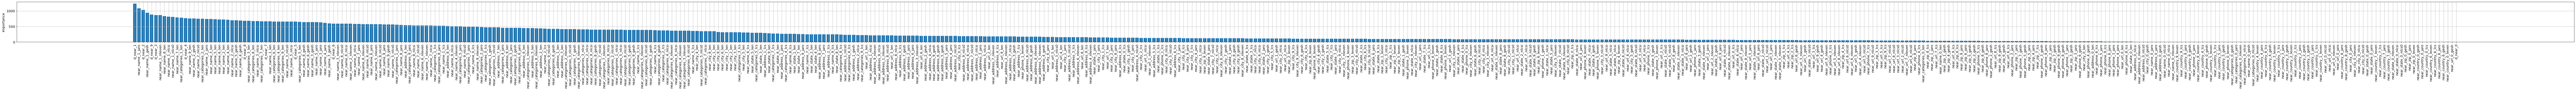

In [45]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue
        
        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

#train = postprocess(train)
test = postprocess(test)
# print(f"CV: {get_score(train):.6f}")

In [ ]:
test

# Submit

In [ ]:
ssub = pd.read_csv("submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv("submission.csv", index=False)

ssub.head()